In [1]:
import pyvista as pv
import numpy as np
from netCDF4 import Dataset

# import all the required libraries (netcdf4, pyvista)

In [2]:
#FIRST WE GET THE DATA FROM THE GCM SIMULATION

# 4D GRID VARIABLES
nc1 = Dataset('diagfi_benchmark_early_Mars.nc')

Time_GCM=nc1.variables['Time'][:]
lat_GCM=nc1.variables['latitude'][:]
lon_GCM=nc1.variables['longitude'][:]
alt_GCM=nc1.variables['altitude'][:]
aire_GCM=nc1.variables['aire'][:][:]

resolution_lon_GCM = abs(lon_GCM[1]-lon_GCM[0])
resolution_lat_GCM = abs(lat_GCM[1]-lat_GCM[0])



# 2D VARIABLES
tsurf1=nc1.variables['tsurf'][:][:][:]
OLR1=nc1.variables['OLR'][:][:][:]
h2o_ice_col1=nc1.variables['h2o_ice_col'][:][:][:]

# 3D VARIABLES
u1=nc1.variables['u'][:][:][:][:]
v1=nc1.variables['v'][:][:][:][:]
w1=nc1.variables['w'][:][:][:][:]
ice1=nc1.variables['h2o_ice'][:][:][:][:]
temp1=nc1.variables['temp'][:][:][:][:]


In [3]:
# DEFINE REFERENCE RADIUS OF THE PLANET
RADIUS = 1.0

# Longitudes and latitudes used to plot the GCM simulation
x = lon_GCM[0:len(lon_GCM)-1]+180.
y = lat_GCM[0:len(lat_GCM)]

# Define polar coordinates
y_polar = 90.0 - y  # grid_from_sph_coords() expects polar angle


# FUNCTION TO CALCULATE COORDINATE CELL BOUNDARIES
def _cell_bounds(points, bound_position=0.5):
    """
    Calculate coordinate cell boundaries.

    Parameters
    ----------
    points: numpy.array
        One-dimensional array of uniformly spaced values of shape (M,)
    bound_position: bool, optional
        The desired position of the bounds relative to the position
        of the points.

    Returns
    -------
    bounds: numpy.array
        Array of shape (M+1,)

    Examples
    --------
    >>> a = np.arange(-1, 2.5, 0.5)
    >>> a
    array([-1. , -0.5,  0. ,  0.5,  1. ,  1.5,  2. ])
    >>> cell_bounds(a)
    array([-1.25, -0.75, -0.25,  0.25,  0.75,  1.25,  1.75,  2.25])
    """
    assert points.ndim == 1, "Only 1D points are allowed"
    diffs = np.diff(points)
    delta = diffs[0] * bound_position
    bounds = np.concatenate([[points[0] - delta], points + delta])
    return bounds


# Create arrays of grid cell boundaries, which have shape of (x.shape[0] + 1)
xx_bounds = _cell_bounds(x)
yy_bounds = _cell_bounds(y_polar)

In [4]:
# 1. PREPARE THE SURFACE LAYER
surface_level = [RADIUS] # surface level
grid_scalar1 = pv.grid_from_sph_coords(xx_bounds, yy_bounds, surface_level)

scalar_surface = np.zeros((len(lat_GCM),len(lon_GCM)-1),dtype='f')
for i_time in range(0,len(Time_GCM),1):
    for i in range(0,len(lat_GCM),1):
        for j in range(0,len(lon_GCM)-1,1):
            scalar_surface[i,j]=scalar_surface[i,j]+tsurf1[i_time,i,j]/len(Time_GCM)

grid_scalar1.cell_arrays["example"] = np.array(scalar_surface).swapaxes(-2, -1).ravel("C")

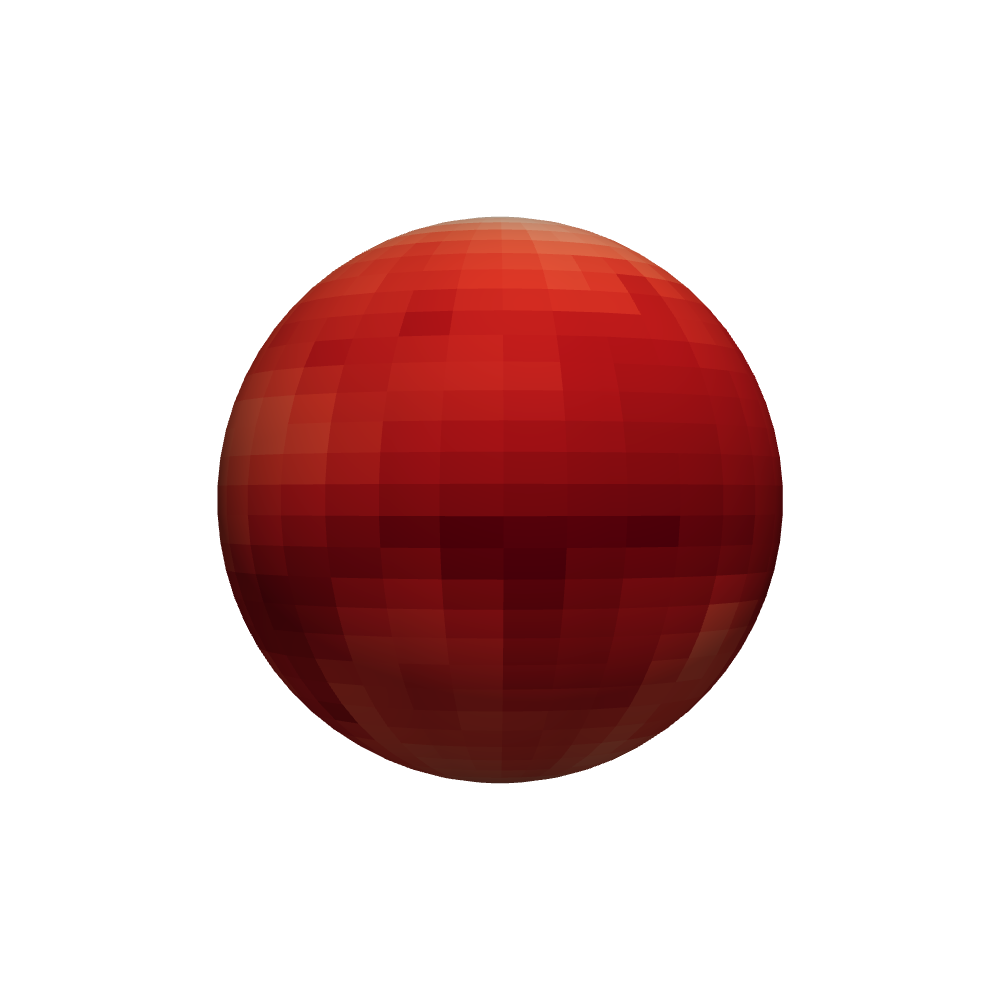

In [7]:
# FIRST PLOT
    
p = pv.Plotter(1)
p.add_mesh(grid_scalar1, opacity=1.0, cmap="Reds", smooth_shading="True",show_scalar_bar=False) #clim=[1,1],
p.camera_position = 'yz'
p.camera.azimuth = 130.
p.camera.roll =270
p.camera.elevation = 0
p.set_background('white')
p.screenshot("surface_temperature_only.png",window_size=[1000,1000])#, transparent_background=True)
p.show()

In [10]:
# 2. CREATE THE 3D SPHERICAL SHELL (GRID LINES)
radial_shell = np.linspace(0, RADIUS*1.2, 15)
xx_shell, yy_shell, zz_shell = np.meshgrid(np.radians(np.arange(90, 365, resolution_lon_GCM)), np.radians(np.arange(-84, 84, resolution_lat_GCM)), radial_shell)
# Transform to spherical coordinates
x_shell = zz_shell * np.cos(yy_shell) * np.cos(xx_shell)
y_shell = zz_shell * np.cos(yy_shell) * np.sin(xx_shell)
z_shell = zz_shell * np.sin(yy_shell)
grid_shell = pv.StructuredGrid(x_shell, y_shell, z_shell)
grid_shell['radials'] = zz_shell.ravel(order='F')

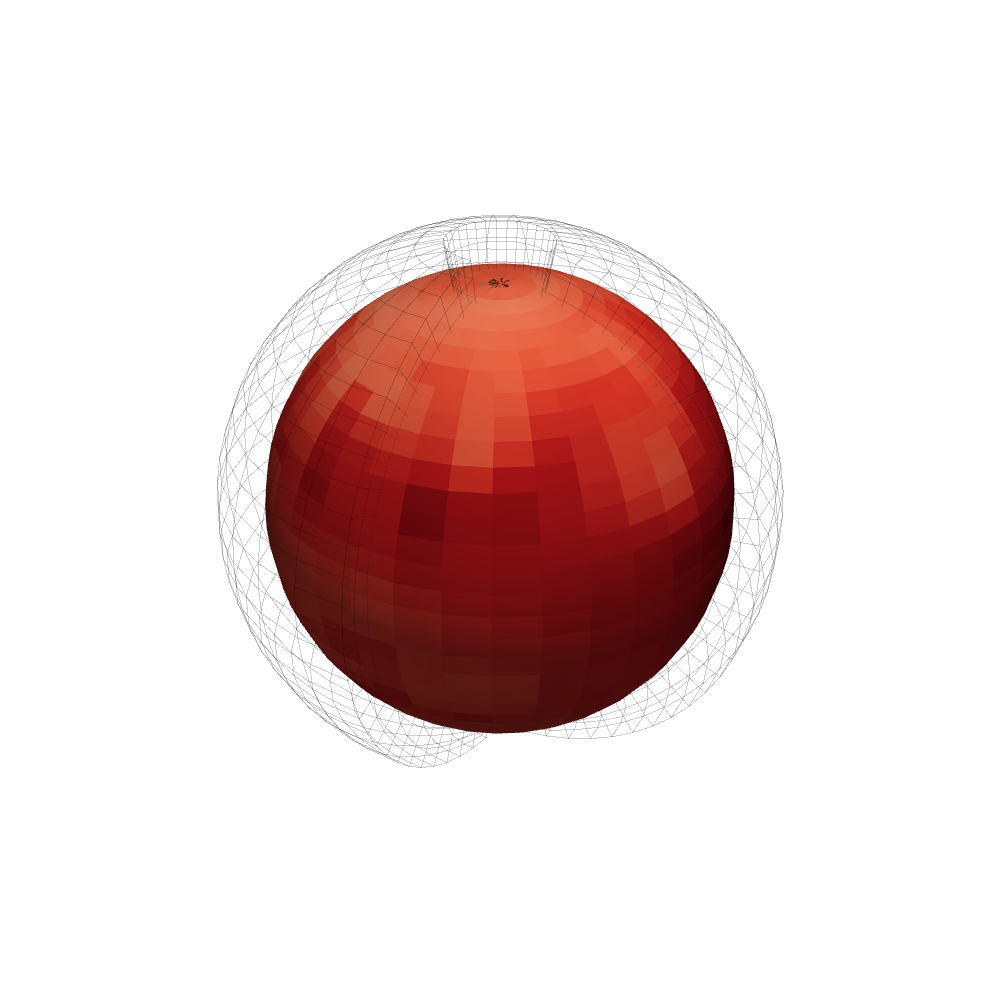

In [11]:
# SECOND PLOT
    
p = pv.Plotter(1)
p.add_mesh(grid_scalar1, opacity=1.0, cmap="Reds", smooth_shading="True",show_scalar_bar=False) #clim=[1,1],
p.add_mesh(grid_shell, style='wireframe',cmap='Greys',opacity=0.1,show_scalar_bar=False)
p.camera_position = 'yz'
p.camera.azimuth = 30.
p.camera.roll =270
p.camera.elevation = 30
p.set_background('white')
p.screenshot("surface_temperature_with_grid.png",window_size=[1000,1000])#, transparent_background=True)
p.show()

In [18]:
# 3. PREPARE THE WIND LAYER

freq_call_wind=2 # used to change the frequency of wind pattern
MULT_FACTOR_ZWIND=100. # scaling factor of vertical wind so that we can see it in the plot
wind_level = [RADIUS * 1.02] # altitude of the wind layer (on the plot)

i_alt=13 # altitude of the wind layer (in the GCM data)

scalar_u_wind = np.zeros((len(lat_GCM),len(lon_GCM)-1),dtype='f')
scalar_v_wind = np.zeros((len(lat_GCM),len(lon_GCM)-1),dtype='f')
scalar_w_wind = np.zeros((len(lat_GCM),len(lon_GCM)-1),dtype='f')

for i_time in range(0,len(Time_GCM),1):
    for i in range(0,len(lat_GCM),1):
        for j in range(0,len(lon_GCM)-1,1):
            scalar_u_wind[i,j]=scalar_u_wind[i,j]+u1[i_time,i_alt,i,j]/len(Time_GCM)
            scalar_v_wind[i,j]=scalar_v_wind[i,j]+v1[i_time,i_alt,i,j]/len(Time_GCM)
            scalar_w_wind[i,j]=scalar_w_wind[i,j]+w1[i_time,i_alt,i,j]/len(Time_GCM)

inv_axes = [*range(scalar_u_wind[::freq_call_wind,::freq_call_wind].ndim)[::-1]]
# Transform vectors to cartesian coordinates
vectors = np.stack(
        [
            i.transpose(inv_axes).swapaxes(-2, -1).ravel("C")
            for i in pv.transform_vectors_sph_to_cart(
                x[::freq_call_wind],
                y_polar[::freq_call_wind],
                wind_level[::freq_call_wind],
                scalar_u_wind[::freq_call_wind,::freq_call_wind].transpose(inv_axes),
                -scalar_v_wind[::freq_call_wind,::freq_call_wind].transpose(inv_axes),  # Minus sign because y-vector in polar coords is required
                -MULT_FACTOR_ZWIND*scalar_w_wind[::freq_call_wind,::freq_call_wind].transpose(inv_axes),
            )
        ],
        axis=1,
    )
# Scale vectors to make them visible
vectors *= RADIUS * 0.01
# Create a grid for the vectors
grid_winds = pv.grid_from_sph_coords(x[::freq_call_wind], y_polar[::freq_call_wind], wind_level)
# Add vectors to the grid
grid_winds.point_arrays["example"] = vectors

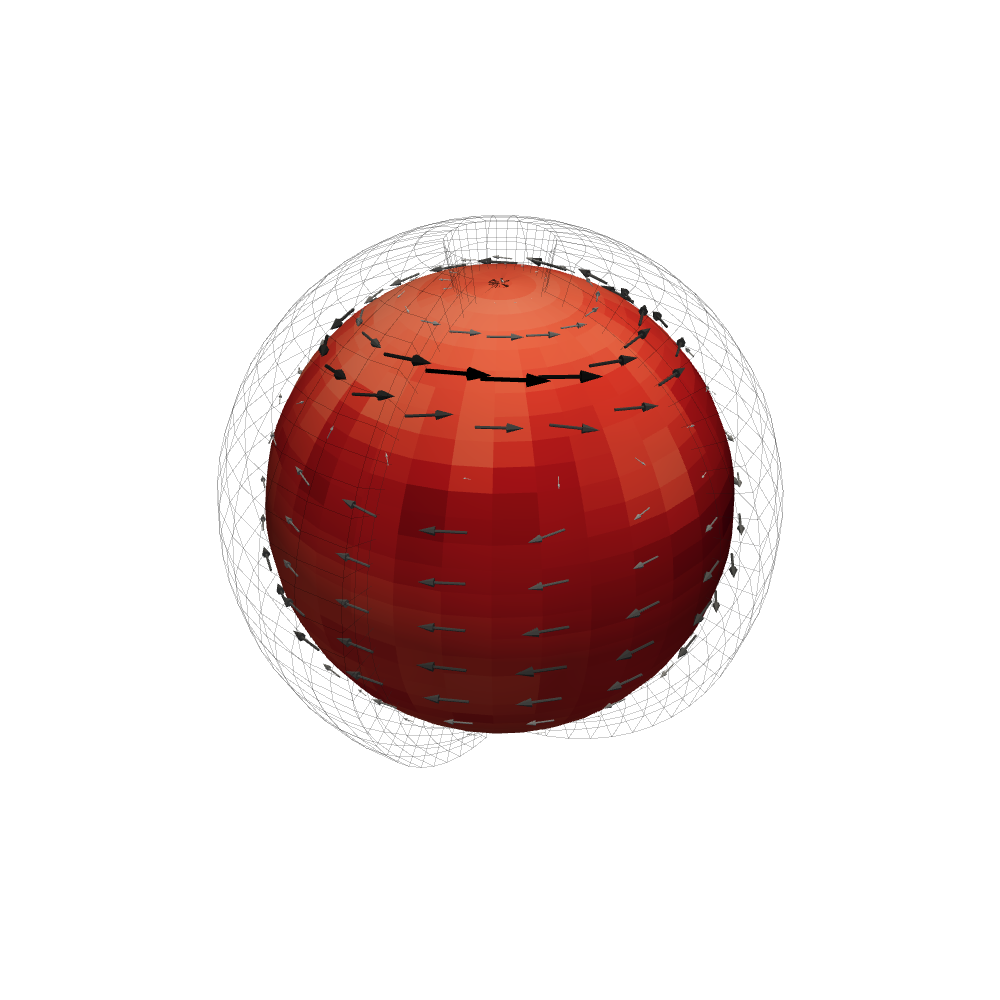

In [19]:
# THIRD PLOT
    
p = pv.Plotter(1)
p.add_mesh(grid_scalar1, opacity=1.0, cmap="Reds", smooth_shading="True",show_scalar_bar=False) #clim=[1,1],
p.add_mesh(grid_shell, style='wireframe',cmap='Greys',opacity=0.1,show_scalar_bar=False)
p.add_mesh(grid_winds.glyph(orient="example", scale="example", tolerance=0.005),cmap="binary",show_scalar_bar=False)
p.camera_position = 'yz'
p.camera.azimuth = 30.
p.camera.roll =270
p.camera.elevation = 30
p.set_background('white')
p.screenshot("surface_temperature_with_grid_with_winds.png",window_size=[1000,1000])#, transparent_background=True)
p.show()

In [20]:
# 4. CREATE THE CLOUD LAYERS (LEVEL 1)

# Number of vertical levels
nlev = 3
table_level=np.arange(nlev)

# artificial empty layers above and below the clouds
table_level[0]=0.
table_level[1]=1.
table_level[2]=0.


scalar_cloud = np.zeros((len(lat_GCM),len(lon_GCM)-1),dtype='f')
for i_time in range(0,len(Time_GCM),1):
    for i in range(0,len(lat_GCM),1):
        for j in range(0,len(lon_GCM)-1,1):
            scalar_cloud[i,j]=scalar_cloud[i,j]+h2o_ice_col1[i_time,i,j]/len(Time_GCM)

# 3D cloud layer
scalar_cloud_3d = (
scalar_cloud.repeat(nlev).reshape((*scalar_cloud.shape, nlev)) * table_level[np.newaxis, np.newaxis, :]).transpose(2, 0, 1)

# geometry of the grid
z_scale = RADIUS/20.
levels2 = z_scale * (np.arange(scalar_cloud_3d.shape[0] + 1)) + RADIUS*1.01
print (levels2)

# Create a structured grid by transforming coordinates
grid_scalar_cloud_3d = pv.grid_from_sph_coords(xx_bounds, yy_bounds, levels2)

# Add data to the grid
grid_scalar_cloud_3d.cell_arrays["example"] = np.array(scalar_cloud_3d).swapaxes(-2, -1).ravel("C")

# Create a set of isosurfaces
surfaces_cloud = grid_scalar_cloud_3d.cell_data_to_point_data().contour(isosurfaces=[0.00005])



[1.01 1.06 1.11 1.16]


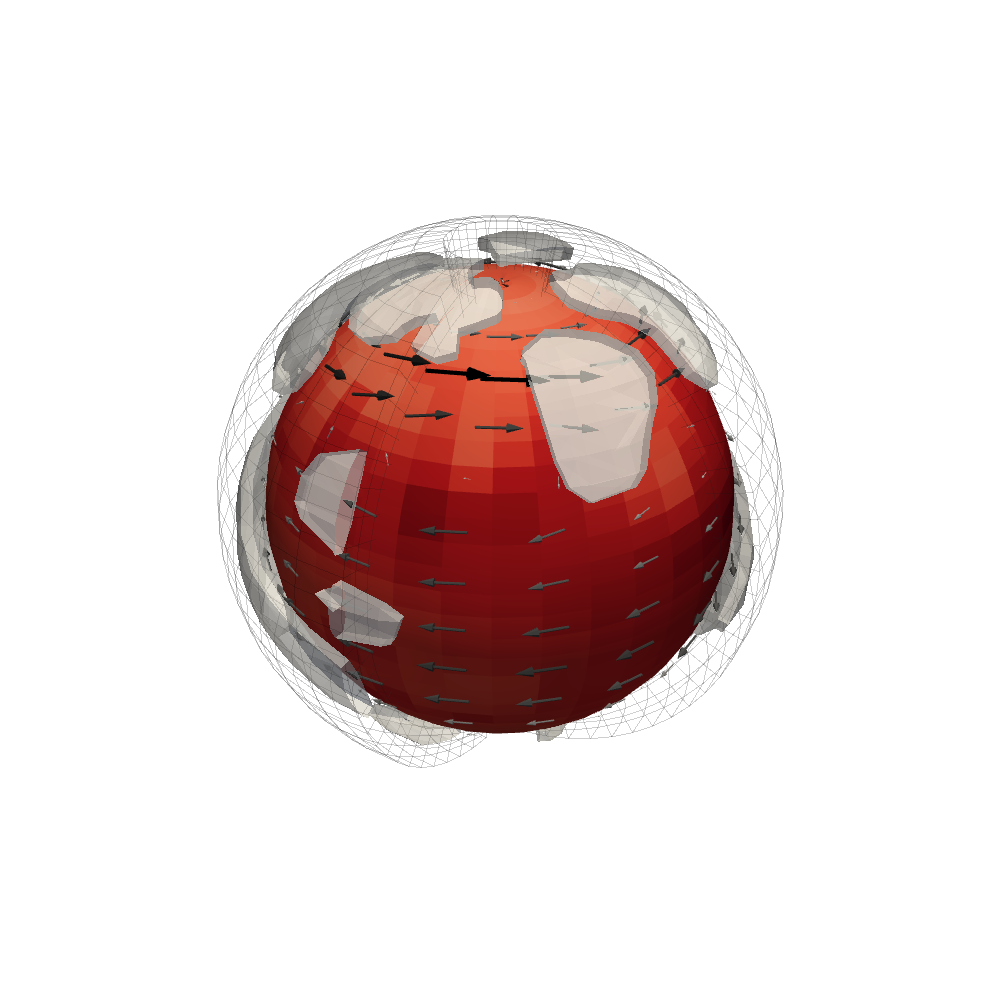

In [21]:
# FOURTH PLOT
    
p = pv.Plotter(1)
p.add_mesh(grid_scalar1, opacity=1.0, cmap="Reds", smooth_shading="True",show_scalar_bar=False) #clim=[1,1],
p.add_mesh(grid_shell, style='wireframe',cmap='Greys',opacity=0.1,show_scalar_bar=False)
p.add_mesh(grid_winds.glyph(orient="example", scale="example", tolerance=0.005),cmap="binary",show_scalar_bar=False)
p.add_mesh(surfaces_cloud,cmap="Greys",opacity=0.7,show_scalar_bar=False)
p.camera_position = 'yz'
p.camera.azimuth = 30.
p.camera.roll =270
p.camera.elevation = 30
p.set_background('white')
p.screenshot("surface_temperature_with_grid_with_winds_with_2D_clouds.png",window_size=[1000,1000])#, transparent_background=True)
p.show()

In [43]:
# 5. CREATE THE CLOUD LAYERS (LEVEL 2)

# Get the 3D field of water ice clouds
scalar_ice = np.zeros((len(lat_GCM),len(lon_GCM)-1,len(alt_GCM)),dtype='f')
for i_time in range(0,len(Time_GCM),1):
    for i in range(0,len(lat_GCM),1):
        for j in range(0,len(lon_GCM)-1,1):
            for k in range(0,len(alt_GCM),1):
                scalar_ice[i,j,k]=scalar_ice[i,j,k]+ice1[i_time,k,i,j]/len(Time_GCM)
            
nlev = len(alt_GCM)+1
table_level=np.arange(nlev)

# geometry of the grid
z_scale = RADIUS/50.
levels2 = RADIUS*1.01+ z_scale * table_level

# 3D cloud layer
scalar_cloud_3d = (np.clip(scalar_ice,0,1.0e8)).transpose(2, 0, 1) # clip to a=amax

# Create a structured grid by transforming coordinates
grid_scalar_cloud_3d = pv.grid_from_sph_coords(xx_bounds, yy_bounds, levels2)

# Add data to the grid
grid_scalar_cloud_3d.cell_arrays["example"] = np.array(scalar_cloud_3d).swapaxes(-2, -1).ravel("C")

# Create a set of isosurfaces
surfaces_cloud = grid_scalar_cloud_3d.cell_data_to_point_data().contour(isosurfaces=[0.9e-8])
            

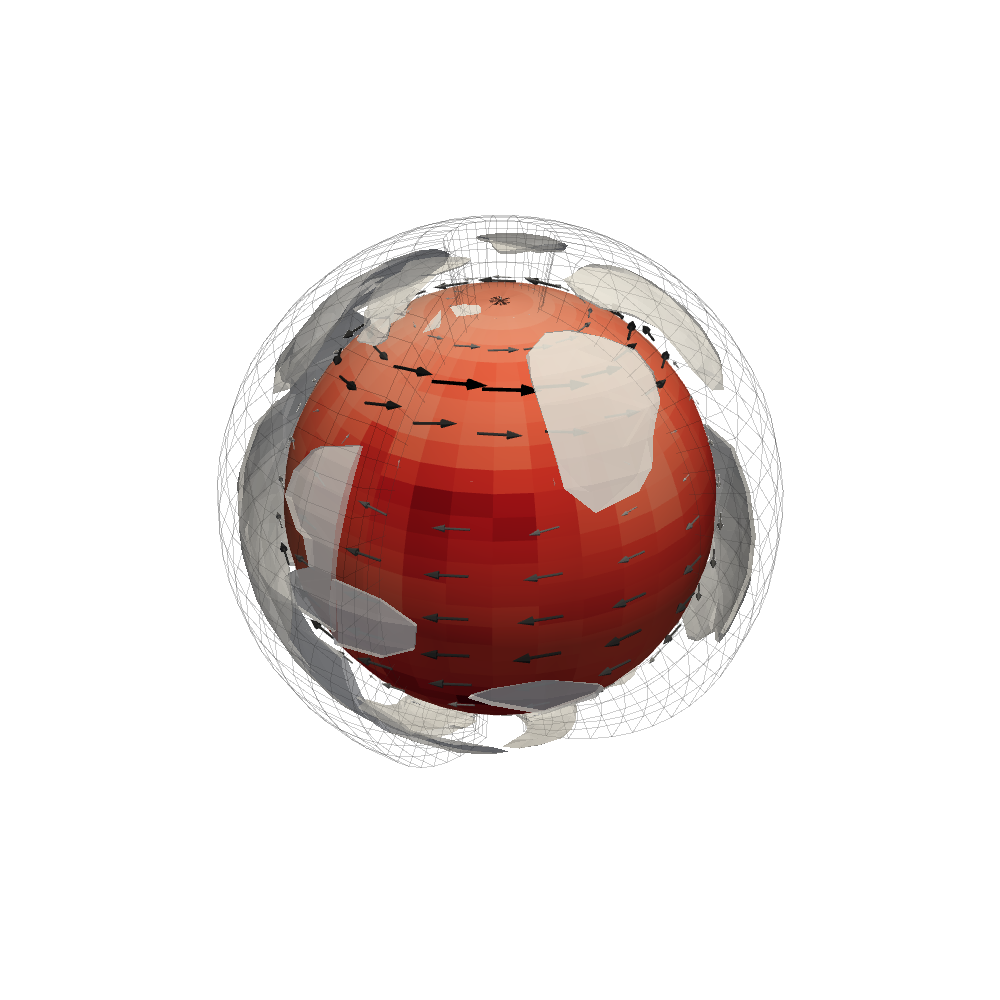

In [44]:
# FOURTH PLOT
    
p = pv.Plotter(1)
p.add_mesh(grid_scalar1, opacity=1.0, cmap="Reds", smooth_shading="True",show_scalar_bar=False) #clim=[1,1],
p.add_mesh(grid_shell, style='wireframe',cmap='Greys',opacity=0.1,show_scalar_bar=False)
p.add_mesh(grid_winds.glyph(orient="example", scale="example", tolerance=0.005),cmap="binary",show_scalar_bar=False)
p.add_mesh(surfaces_cloud,cmap="Greys",opacity=0.7,show_scalar_bar=False)
p.camera_position = 'yz'
p.camera.azimuth = 30.
p.camera.roll =270
p.camera.elevation = 30
p.set_background('white')
p.screenshot("surface_temperature_with_grid_with_winds_with_3D_clouds.png",window_size=[1000,1000])#, transparent_background=True)
p.show()

In [45]:
#FINALLY WE MAKE THE GIF

total_step_gif=100
for i in range(0,total_step_gif,1):
    p = pv.Plotter(i)
    p.add_mesh(grid_scalar1, opacity=1.0, cmap="Reds", smooth_shading="True",show_scalar_bar=False) #clim=[1,1],
    p.add_mesh(grid_shell, style='wireframe',cmap='Greys',opacity=0.1,show_scalar_bar=False)
    p.add_mesh(grid_winds.glyph(orient="example", scale="example", tolerance=0.005),cmap="binary",show_scalar_bar=False)
    p.add_mesh(surfaces_cloud,cmap="Greys",opacity=0.7,show_scalar_bar=False)
    p.camera_position = 'yz'
    p.camera.azimuth = i*360/total_step_gif
    p.camera.roll += 0.
    p.camera.elevation = 30
    p.set_background('white')
    if(i<10):
        p.screenshot("gif_planet_000"+str(i)+".png",window_size=[1000,1000])#, transparent_background=True)
    if((i>=10) and (i_time<100)):
        p.screenshot("gif_planet_00"+str(i)+".png",window_size=[1000,1000])#, transparent_background=True)
    if((i>=100) and (i_time<1000)):
        p.screenshot("gif_planet_0"+str(i)+".png",window_size=[1000,1000])#, transparent_background=True)
    if((i>=1000) and (i_time<10000)):
        p.screenshot("gif_planet_"+str(i)+".png",window_size=[1000,1000])#, transparent_background=True)
    print("we are at step = ", i, "/",total_step_gif)

print('OPERATION FINISHED')

we are at step =  0 / 100
we are at step =  1 / 100
we are at step =  2 / 100
we are at step =  3 / 100
we are at step =  4 / 100
we are at step =  5 / 100
we are at step =  6 / 100
we are at step =  7 / 100
we are at step =  8 / 100
we are at step =  9 / 100
we are at step =  10 / 100
we are at step =  11 / 100
we are at step =  12 / 100
we are at step =  13 / 100
we are at step =  14 / 100
we are at step =  15 / 100
we are at step =  16 / 100
we are at step =  17 / 100
we are at step =  18 / 100
we are at step =  19 / 100
we are at step =  20 / 100
we are at step =  21 / 100
we are at step =  22 / 100
we are at step =  23 / 100
we are at step =  24 / 100
we are at step =  25 / 100
we are at step =  26 / 100
we are at step =  27 / 100
we are at step =  28 / 100
we are at step =  29 / 100
we are at step =  30 / 100
we are at step =  31 / 100
we are at step =  32 / 100
we are at step =  33 / 100
we are at step =  34 / 100
we are at step =  35 / 100
we are at step =  36 / 100
we are at s

In [15]:
#GIF WITH VARIATION OF CAMERA ELEVATION

total_step_gif=100
for i in range(0,total_step_gif,1):
    p = pv.Plotter(i)
    p.add_mesh(grid_scalar1, opacity=1.0, cmap="Reds", smooth_shading="True",show_scalar_bar=False) #clim=[1,1],
    p.add_mesh(grid_shell, style='wireframe',cmap='Greys',opacity=0.1,show_scalar_bar=False)
    p.add_mesh(grid_winds.glyph(orient="example", scale="example", tolerance=0.005),cmap="binary",show_scalar_bar=False)
    p.add_mesh(surfaces_cloud,cmap="Greys",opacity=0.7,show_scalar_bar=False)
    p.camera_position = 'yz'
    p.camera.azimuth = i*360/total_step_gif
    p.camera.roll += 0.
    p.camera.elevation = 45+15*np.cos((i*360/total_step_gif)*np.pi/180.)
    p.set_background('white')
    if(i<10):
        p.screenshot("gif_planet_000"+str(i)+".png",window_size=[1000,1000])#, transparent_background=True)
    if((i>=10) and (i_time<100)):
        p.screenshot("gif_planet_00"+str(i)+".png",window_size=[1000,1000])#, transparent_background=True)
    if((i>=100) and (i_time<1000)):
        p.screenshot("gif_planet_0"+str(i)+".png",window_size=[1000,1000])#, transparent_background=True)
    if((i>=1000) and (i_time<10000)):
        p.screenshot("gif_planet_"+str(i)+".png",window_size=[1000,1000])#, transparent_background=True)
    print("we are at step = ", i, "/",total_step_gif)

print('OPERATION FINISHED')

we are at step =  0 / 100
we are at step =  1 / 100
we are at step =  2 / 100
we are at step =  3 / 100
we are at step =  4 / 100
we are at step =  5 / 100
we are at step =  6 / 100
we are at step =  7 / 100
we are at step =  8 / 100
we are at step =  9 / 100
we are at step =  10 / 100
we are at step =  11 / 100
we are at step =  12 / 100
we are at step =  13 / 100
we are at step =  14 / 100
we are at step =  15 / 100
we are at step =  16 / 100
we are at step =  17 / 100
we are at step =  18 / 100
we are at step =  19 / 100
we are at step =  20 / 100
we are at step =  21 / 100
we are at step =  22 / 100
we are at step =  23 / 100
we are at step =  24 / 100
we are at step =  25 / 100
we are at step =  26 / 100
we are at step =  27 / 100
we are at step =  28 / 100
we are at step =  29 / 100
we are at step =  30 / 100
we are at step =  31 / 100
we are at step =  32 / 100
we are at step =  33 / 100
we are at step =  34 / 100
we are at step =  35 / 100
we are at step =  36 / 100
we are at s